In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
names=[name.strip() for name in open('names.txt', 'r')]


In [ ]:
names[0:3]

['emma', 'olivia', 'ava']

In [ ]:
len(names)

32033

In [ ]:
# Building vocabulary and lookup tables
vocab=sorted(list(set("".join(names))))
stoi={char: i+1 for i, char in enumerate(vocab)}
stoi["."]=0
itos={value: key for key,value in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
#hyper_parameters
emb_dimension=18
h_size=300
n_epoches=30000
mini_batch_size=30
i_lr=0.8
block_size = 4 # context length: how many characters do we take to predict the next one?

In [ ]:
# build the dataset
def build_dataset(names):
  X, Y = [], []
  for w in names:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [ ]:
# initialization
vocab_size=len(vocab)+1
i_size= block_size* emb_dimension
g=torch.Generator().manual_seed(42)
C= torch.randn((vocab_size,emb_dimension),generator=g)
W1= torch.randn((i_size,h_size),generator=g) #/ ((5/3)*(i_size)**0.5)  # Kaiming init we want our weights and biases are such a way that the activations inputs are close to zero i.e less extreme more near mean, i.e gaussian, so inorder to do that we multiply weights and biases such that mean and standard deviation stays gaussian
b1=torch.randn(h_size, generator=g) #/ ((5/3)*(h_size)**0.5)
W2=torch.randn((h_size,vocab_size),generator=g) * 0.01
b2=torch.zeros(vocab_size) # We don't want to initialize randomly , which causes high initial loss, but we need biase for later, so we initialize them with zeroes
bngain= torch.ones(1, h_size)
bnbias=torch.zeros(1,h_size)
parameters=[C,W1,b1,W2,b2, bngain, bnbias]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

31113

In [ ]:
for p in parameters:
  p.requires_grad=True

In [ ]:
# ideal initial loss
-torch.tensor(1/27).log()

tensor(3.2958)

In [ ]:
# Using above tuned hyperparameters in training:
# inorder to increase number of epoches to compute we use mini batches of data
epoch=[]
loss=[]
for epoch in range(n_epoches):
  ix=torch.randint(0,Xtr.shape[0], (mini_batch_size,))
  # forward pass
  emb=C[Xtr[ix]]
  hpreact=emb.view(-1,i_size) @ W1 #+b1
  hguass= bngain * ((hpreact-hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)) + bnbias
  h=torch.tanh(hguass)
  logits=h @ W2 + b2
  loss=F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in parameters:
    p.grad=None
  loss.backward()
  # update param
  # lr decay, as we are reaching the minima we need to decrease the lr so that it converges instead of overshooting
  lr = i_lr*0.1 if epoch > 0.8*n_epoches else i_lr
  for p in parameters:
    p.data+=-lr*p.grad
  if epoch%1000==0:
    print(f"{epoch}/{n_epoches}",loss.item())


0/30000 3.2728915214538574
1000/30000 2.06657338142395
2000/30000 2.7562363147735596
3000/30000 2.583792209625244
4000/30000 2.4998154640197754
5000/30000 2.3923003673553467
6000/30000 2.192539930343628
7000/30000 2.677978515625
8000/30000 2.3956992626190186
9000/30000 2.3617234230041504
10000/30000 2.4802589416503906
11000/30000 2.4071950912475586
12000/30000 2.3346052169799805
13000/30000 2.1232149600982666
14000/30000 2.288477897644043
15000/30000 2.358973741531372
16000/30000 2.3430418968200684
17000/30000 2.3194541931152344
18000/30000 2.2007880210876465
19000/30000 2.0529513359069824
20000/30000 2.5389404296875
21000/30000 2.415105104446411
22000/30000 2.2285468578338623
23000/30000 2.391490936279297
24000/30000 2.376664876937866
25000/30000 2.3673317432403564
26000/30000 1.9718173742294312
27000/30000 2.1686654090881348
28000/30000 2.086977243423462
29000/30000 2.0243043899536133


In [ ]:
# h=tanh(h_hidden), if h=+1 or -1 can cause some problems, h.grad would be 0 for that neuron , which means when we bp this grad would zero out gradients of the chain , so weights and biases that depends on that neuron won't get updated, wasted potential
# dead neuron , so we dont want high h_hidden
h

tensor([[-0.0159, -0.0044, -0.0123,  ...,  0.0044,  0.0034, -0.0049],
        [-0.0816, -0.0043,  0.0325,  ..., -0.0363, -0.0015,  0.0168],
        [-0.0159, -0.0044, -0.0123,  ...,  0.0044,  0.0034, -0.0049],
        ...,
        [ 0.0381, -0.0054,  0.2491,  ..., -0.5412,  0.0095,  0.0062],
        [-0.0482, -0.0040,  0.1896,  ..., -0.1588,  0.0063, -0.0057],
        [ 0.0241, -0.0046, -0.0218,  ..., -0.0851,  0.0058,  0.0145]],
       grad_fn=<TanhBackward0>)

In [ ]:
h.shape

torch.Size([30, 300])

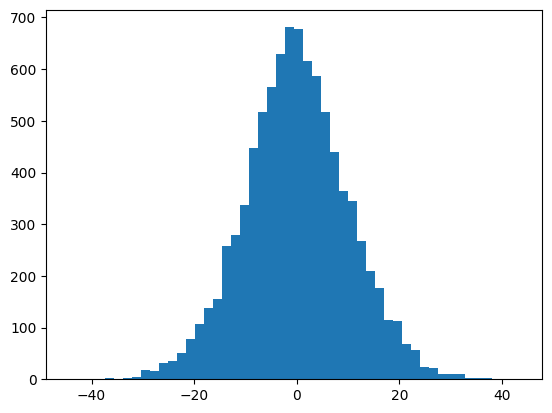

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [ ]:
h.mean().item()

-0.0011434369953349233

In [ ]:
h.std().item()

0.19372527301311493

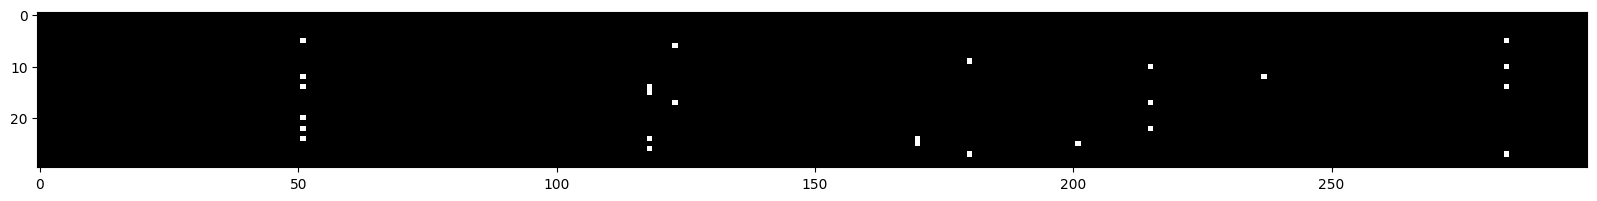

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")
# lot of white space , if somehow initial weights are initialised such a way, for every example a particular neuron activation is greater than 0.99, then gradients of weights and biases that would alter those values would be 0, so that neuron would never learn, which means its a dead neuron, , so anyhow we are decreasing the chance of network to learn when activations are very high, so we want to avoid that.

In [ ]:
with torch.no_grad():
  emb=C[Xtr]
  hpreact=emb.view(-1,i_size) @ W1 +b1
  bnmean= hpreact.mean(0, keepdim=True)
  bnstd=hpreact.std(0,keepdim=True)



In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]  # Assuming C is a tensor or some embedding matrix
    hpreact=emb.view(-1,i_size) @ W1 +b1
    hguass= bngain * ((hpreact-bnmean)/bnstd) + bnbias
    h=torch.tanh(hguass)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)  # Use the correct target tensor y
    return loss.item()

train_loss = split_loss('train')
dev_loss = split_loss('dev')
test_loss = split_loss('test')

In [ ]:
# loss on whole train data
train_loss

2.2005653381347656

In [ ]:
# loss on whole dev data
dev_loss

2.2061233520507812

In [ ]:
# testing loss on test data
# loss on whole test data
test_loss

2.208721399307251

In [ ]:
# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [ ]:
# generate new names
for i in range(10):
  context=[0]*block_size
  context=[0] * block_size
  name=[]
  while True:
    emb=C[context]
    hpreact=emb.view(-1,i_size) @ W1 +b1
    hguass=bngain * ((hpreact-bnmean)/bnstd) + bnbias
    h=torch.tanh(hguass)
    logits=h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix= torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
    context = context[1:] + [ix]
    name.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in name))


suky.
dmari.
jorriette.
koprrysh.
ezmie.
kraylen.
aithy.
blerina.
rulous.
myston.
